# Loading Data into Google Cloud

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:40<00:00, 23.3MB/s]
100% 812M/812M [00:40<00:00, 20.9MB/s]


In [2]:
! unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [3]:
! unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [4]:
import os, shutil

In [5]:
original_dataset_dir = 'train'

# The directory where we will
# store our smaller dataset
base_dir = '/cats_and_dogs_small'
try:
  os.mkdir(base_dir)
except:
  pass

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
try:
  os.mkdir(train_dir)
except:
  pass
validation_dir = os.path.join(base_dir, 'validation')
try:
  os.mkdir(validation_dir)
except:
  pass

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
try:
  os.mkdir(train_cats_dir)
except:
  pass

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
try:
  os.mkdir(train_dogs_dir)
except:
  pass

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
try:
  os.mkdir(validation_cats_dir)
except:
  pass

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
try:
  os.mkdir(validation_dogs_dir)
except:
  pass



# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 12500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)


In [6]:
print("Number of training cat images:", len(os.listdir(train_cats_dir)))
print("Number of training dogs images:", len(os.listdir(train_dogs_dir)))
print("Number of Validation cat images:", len(os.listdir(validation_cats_dir)))
print("Number of Validation cat images:", len(os.listdir(validation_dogs_dir)))

Number of training cat images: 10000
Number of training dogs images: 10000
Number of Validation cat images: 2500
Number of Validation cat images: 2500


# Data Preprocessing

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [82]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 100,
    class_mode = 'binary'
)

validation_genertor = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 100,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Model

In [83]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import VGG16

In [85]:
# remove previous model
clear_session()

# basic model
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

# model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

# Freeze VGG16 Weights
conv_base.trainable = False

In [86]:
# Compiling the Model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

## Model Summary

In [87]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1

## Model Architecture

In [89]:
from tensorflow.keras.utils import plot_model

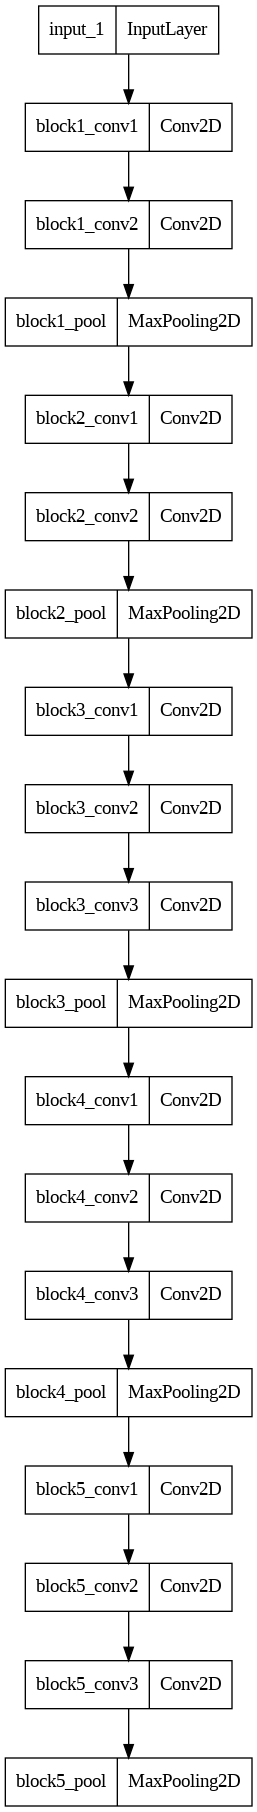

In [90]:
plot_model(conv_base)

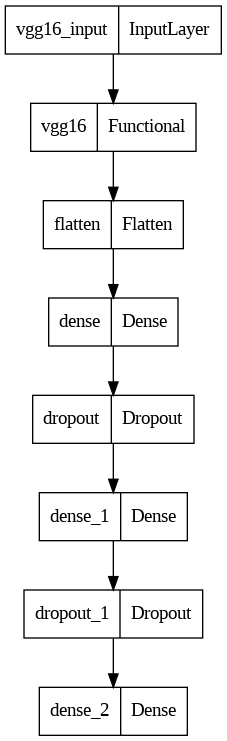

In [91]:
plot_model(model)

# Training the Model

In [92]:
history = model.fit(
    train_generator,
    steps_per_epoch = 200,
    validation_data = validation_genertor,
    validation_steps = 25,
    epochs = 15
)

Epoch 1/15
200/200 [==============================] - 58s 280ms/step - loss: 0.3114 - acc: 0.8626 - val_loss: 0.2540 - val_acc: 0.8932
Epoch 2/15
200/200 [==============================] - 49s 247ms/step - loss: 0.2127 - acc: 0.9103 - val_loss: 0.2358 - val_acc: 0.9032
Epoch 3/15
200/200 [==============================] - 54s 272ms/step - loss: 0.1785 - acc: 0.9266 - val_loss: 0.2466 - val_acc: 0.8932
Epoch 4/15
200/200 [==============================] - 49s 245ms/step - loss: 0.1620 - acc: 0.9315 - val_loss: 0.2034 - val_acc: 0.9176
Epoch 5/15
200/200 [==============================] - 50s 249ms/step - loss: 0.1454 - acc: 0.9396 - val_loss: 0.2218 - val_acc: 0.9124
Epoch 6/15
200/200 [==============================] - 56s 277ms/step - loss: 0.1173 - acc: 0.9523 - val_loss: 0.2438 - val_acc: 0.9100
Epoch 7/15
200/200 [==============================] - 54s 267ms/step - loss: 0.0997 - acc: 0.9595 - val_loss: 0.2487 - val_acc: 0.9076
Epoch 8/15
200/200 [==============================] - 5

# Training vs Validation Accuracy

In [93]:
import matplotlib.pyplot as plt

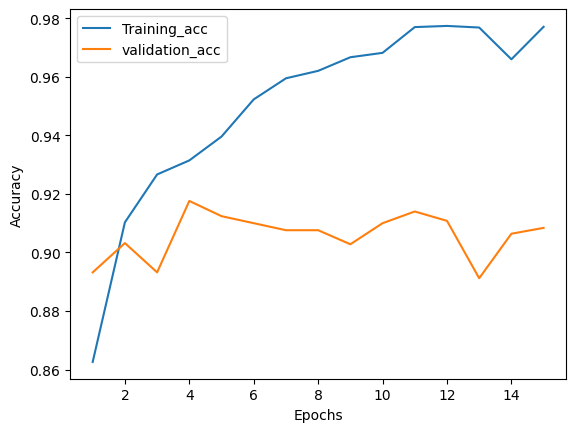

In [94]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training_acc')
plt.plot(epochs, val_acc, label='validation_acc')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

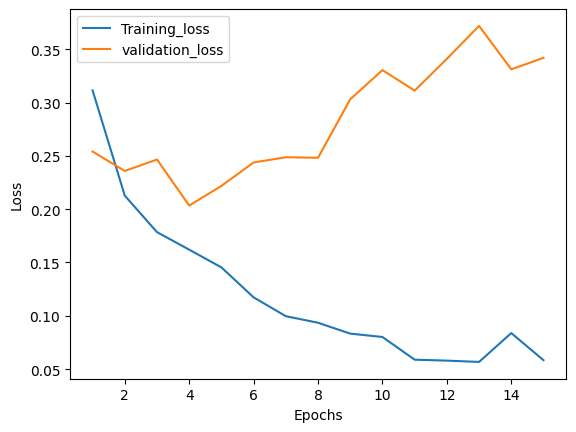

In [95]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training_loss')
plt.plot(epochs, val_loss, label='validation_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()